In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


import glob
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse
from scipy.sparse.linalg import svds


from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df_text_ic = pd.read_csv('../data/df_text_ic.csv')

In [3]:
df_text_ic.shape #(263941, 32)
df_text_ic.head()
# df_text_ic = df_text_ic.drop(['Unnamed: 0.1', 'Unnamed: 0'])
df_text_ic.columns

df_text_ic.head()
df_text_ic.shape #(263941, 30)
df_text_ic.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'subject_id', 'hadm_id', 'icd',
       'long_title', 'chief_complaint', 'surgical_invasive_procedure',
       'history_present_illness', 'past_medcal_history', 'social_history',
       'family_history', 'physical_exam', 'discharge', 'pertinent_results',
       'hospital_course', 'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction', 'icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85'],
      dtype='object')

In [4]:
df_text_ic.head()

,Unnamed: 0.1,Unnamed: 0,subject_id,hadm_id,icd,long_title,chief_complaint,surgical_invasive_procedure,history_present_illness,past_medcal_history,...,followup_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,0,0,10000980,29654838,I50,"Congestive heart failure, unspecified",Shortness of breath\n,None\n,"___ yo woman with h/o hypertension, hyperlipid...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",...,___\n,1,1,0,0,0,1,0,0,0
1,1,2,10000980,26913865,I50,Acute on chronic systolic heart failure,dyspnea\n,Cardiac catheterization ___\n\n,"This is a ___ M with history of diabetes, dias...",- hypertension\n- diabetes\n- hx CVA (cerebell...,...,___\n,1,0,0,0,0,1,0,0,0
2,2,4,10000980,24947999,I50,Acute on chronic systolic heart failure,Dyspnea and chest tightness\n,___ Pharmacologic nuclear stress test\n,"___ year old female with history of HTN, HLD, ...",- hypertension \n- diabetes \n- hx CVA (cere...,...,___\n,1,1,0,0,0,1,0,0,0
3,3,6,10000980,25242409,I50,"Congestive heart failure, unspecified",DVT\n,EGD\n\n,This is a ___ y/o female with PMHx significant...,- hypertension \n- diabetes \n- hx CVA (cere...,...,___\n,1,1,0,0,0,1,1,1,0
4,4,8,10000980,25911675,I50,Acute on chronic systolic (congestive) heart f...,"fatigue, anemia\n",None\n\n,Ms. ___ is a ___ year old woman with a past me...,- hypertension \n- diabetes \n- hx CVA (cere...,...,___\n,1,0,0,0,0,1,0,0,0


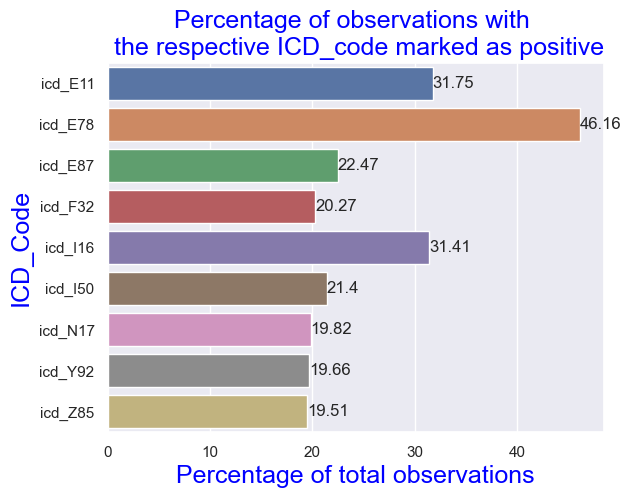

In [58]:
sns.set(style="darkgrid")
df = round((((df_text_ic[['icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85']].sum())*100)/len(df_text_ic)), 2).to_frame().reset_index().rename(columns={'index': 'ICD_code',
                                                                                         0: 'percent_Count'})
ax = sns.barplot(data=df, y='ICD_code', x="percent_Count")

for i in ax.containers:
    ax.bar_label(i,)


# plt.barh(df.ICD_code, df.percent_Count)
# plt.xticks(rotation=90)
plt.xlabel("Percentage of total observations", fontsize=18, color='blue')
plt.ylabel("ICD_Code", fontsize=18, color='blue')
plt.title("Percentage of observations with \n the respective ICD_code marked as positive", fontsize=18, color='blue')
plt.show()

Text(0.5, 0, 'Number of categories')

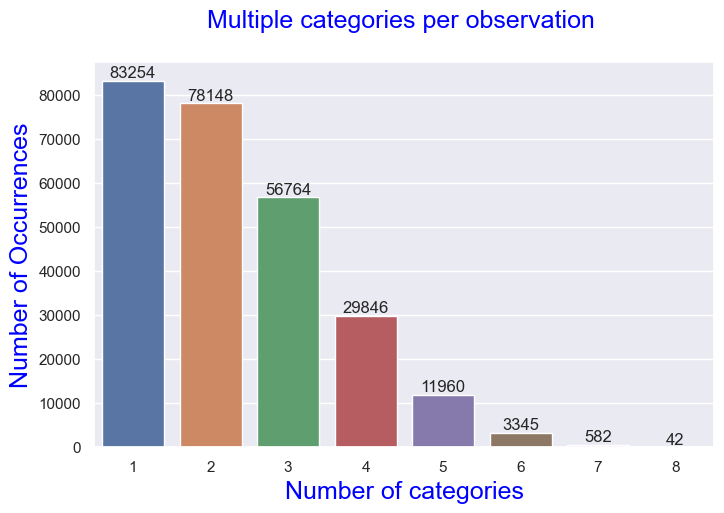

In [57]:
#how many observations have mutiple labels
sns.set(style="darkgrid")
rowsums = df_text_ic.loc[:,['icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85']].sum(axis=1)
x=rowsums.value_counts()
x
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x= x.index, y=x.values)

for i in ax.containers:
    ax.bar_label(i,)

#how to plot broke y-axis
# f, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3,
#                              sharex=True)
# ax1 = sns.barplot(x= x.index, y=x.values, ax=ax1)
# ax2 = sns.barplot(x= x.index, y=x.values, ax=ax2)
# ax3 = sns.barplot(x= x.index, y=x.values, ax=ax3)

# ax1.set_ylim(30000, 80000)
# ax2.set_ylim(1500, 10000)
# ax3.set_ylim(0, 500)

# ax1.get_xaxis().set_visible(False)
# ax2.get_xaxis().set_visible(False)

# ax1.set_ylabel("")
# ax2.set_ylabel("")
# ax3.set_ylabel("")
# f.text(0.05, 0.55, "'# of Occurrences'", va="center", rotation="vertical")

plt.title("Multiple categories per observation \n", fontsize=18, color='blue')
plt.ylabel('Number of Occurrences', fontsize=18, color='blue')
plt.xlabel('Number of categories', fontsize=18, color='blue')

In [6]:
x

1    83254
2    78148
3    56764
4    29846
5    11960
6     3345
7      582
8       42
dtype: int64

In [ ]:
# 'icd_E11', 'icd_E78',
#        'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
# #        'icd_Z85'

In [294]:
print('Percentage of ICD that are not labelled:')
(print(len(df_text_ic[(df_text_ic['icd_E11']==0) &
                      (df_text_ic['icd_E78']==0) & 
                      (df_text_ic['icd_E87']==0) & 
                      (df_text_ic['icd_F32']==0) & 
                      (df_text_ic['icd_I16']==0) & 
                     (df_text_ic['icd_I50']==0) &
                     (df_text_ic['icd_N17']==0) &
                     (df_text_ic['icd_Y92']==0) &
                     (df_text_ic['icd_Z85']==0)]) / len(df)))

Percentage of ICD that are not labelled:
0.0


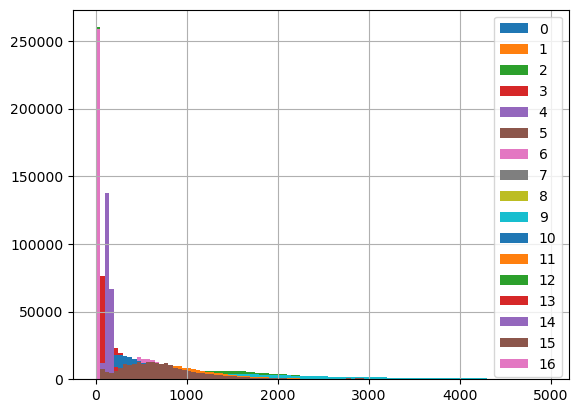

In [7]:
#The distribution of the number of words in comment texts.

text_cat = ['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']
import plotly.express as px
  
fig, ax = plt.subplots()
for i, column in enumerate(text_cat):
    lens = df_text_ic[column].str.len()
    lens.hist(bins = np.arange(0,5000,50), label=i)
#     sns.boxplot(ax=ax, y=lens, x=i*np.ones_like(lens))
plt.legend()
    
#     px.histogram(lens) 
#     fig.show()
#sub_plot


In [8]:
df_len = df_text_ic[['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']]

In [9]:
# # ax1 = plt.hist(df_len.chief_complaint.str.len())



# fig = plt.figure()
# gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
# (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
# fig.suptitle('Sharing x per column, y per row')
# ax1.hist(df_len.family_history.str.len())
# ax2.hist(df_len.discharge_instruction.str.len())
# ax3.plot(x + 1, -y, 'tab:green')
# ax4.plot(x + 2, -y**2, 'tab:red')

# for ax in fig.get_axes():
#     ax.label_outer()

In [11]:
text_cat = ['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']

len_dic_str = {}
x = []
for i in text_cat:
    str_length = df_text_ic[i].str.len()
    x.append(str_length)

    len_dic_str[i] = x
    print(len_dir_str)

NameError: name 'len_dir_str' is not defined

In [12]:
len_call = df_text_ic[text_cat].apply(lambda x:x.str.len()).melt()

Text(0.5, 0, 'Length of the text string')

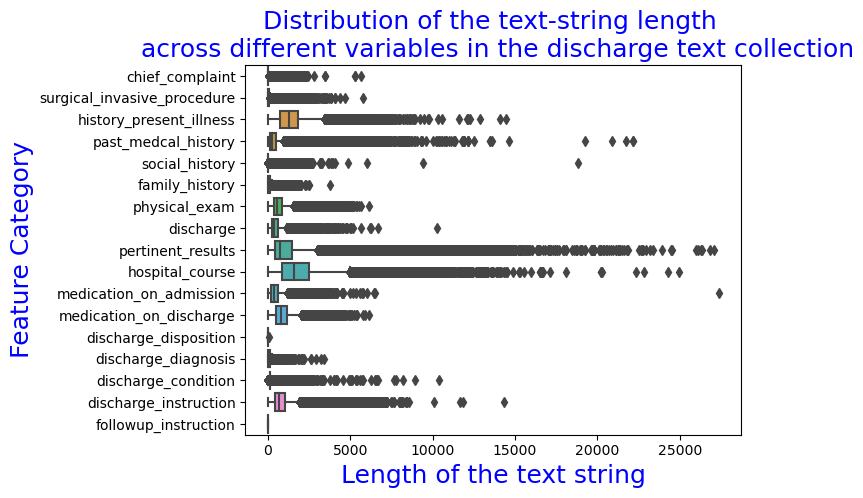

In [30]:
len_call.head()

sns.boxplot(data=len_call, y='variable', x='value')
plt.title('Distribution of the text-string length \n across different variables in the discharge text collection', fontsize=18,
         color='blue')
plt.ylabel('Feature Category', fontsize=18, color="blue")
plt.xlabel('Length of the text string', fontsize=18, color="blue")

Text(0.5, 0, 'Length of the text string')

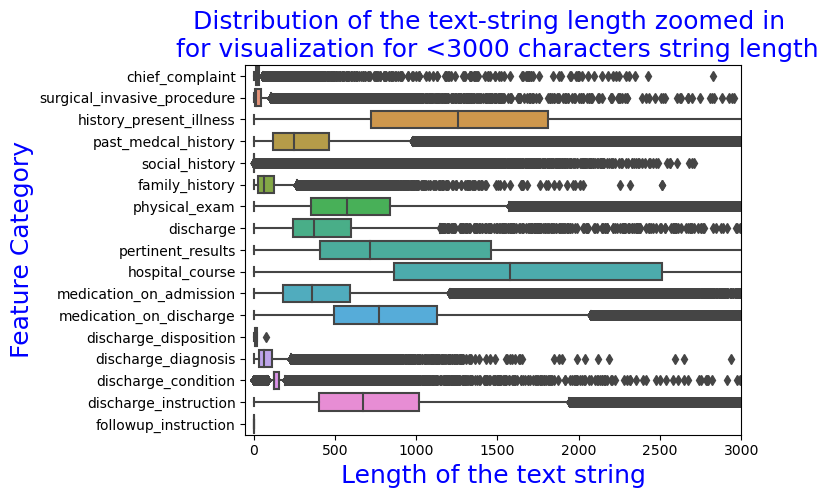

In [29]:
len_call.head()

sns.boxplot(data=len_call, y='variable', x='value')
plt.xlim(-50,3000)
plt.title('Distribution of the text-string length zoomed in \n for visualization for <3000 characters string length', fontsize=18,
         color='blue')
plt.ylabel('Feature Category', fontsize=18, color="blue")
plt.xlabel('Length of the text string', fontsize=18, color="blue")

In [27]:
#length of the string in text per column

text_cat = ['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']

len_dic = {}
for i in text_cat:
    avg_length = df_text_ic[i].str.len().mean()

    len_dic[i] = avg_length
    print(i, avg_length)
# pd.DataFrame(len_dic)

chief_complaint 26.63749872512023
surgical_invasive_procedure 43.27068144111782
history_present_illness 1338.3546448150678
past_medcal_history 390.9412750578889
social_history 14.60800314123099
family_history 89.78513321685958
physical_exam 650.2739529922156
discharge 545.0770224864306
pertinent_results 1207.2725091447994
hospital_course 1871.7607907286717
medication_on_admission 439.7595137824651
medication_on_discharge 857.6061432389511
discharge_disposition 11.890147247143698
discharge_diagnosis 87.73823027125779
discharge_condition 127.02810335591379
discharge_instruction 813.5096734494198
followup_instruction 4.0


In [28]:
#convert the qvg length of string text into df from dic created 
#pd.transpose() coverts row to columns.

feature_text_length = (pd.DataFrame(len_dic, index=[0])).transpose().reset_index().rename(columns= {'index':'feature_category',
                                                                             0 : 'avg_length_of_text_string'})
feature_text_length

,feature_category,avg_length_of_text_string
0,chief_complaint,26.637499
1,surgical_invasive_procedure,43.270681
2,history_present_illness,1338.354645
3,past_medcal_history,390.941275
4,social_history,14.608003
5,family_history,89.785133
6,physical_exam,650.273953
7,discharge,545.077022
8,pertinent_results,1207.272509
9,hospital_course,1871.760791


Text(0.5, 0, 'Length of the text string')

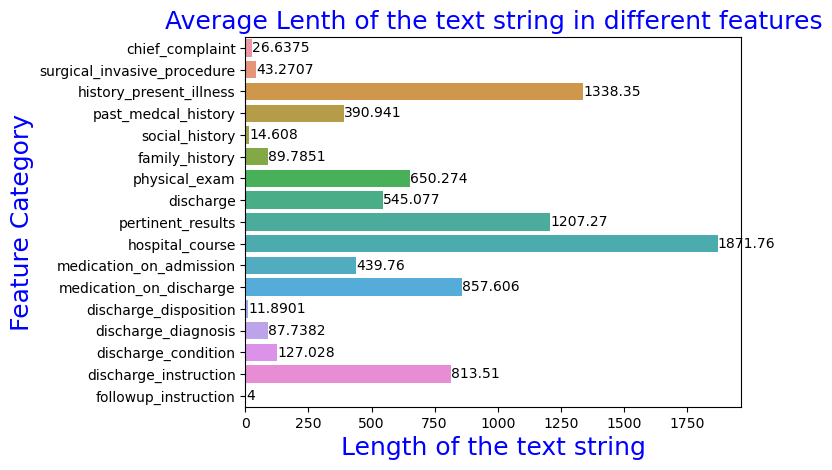

In [40]:
df=feature_text_length
ax = sns.barplot(data=df, x='avg_length_of_text_string', y='feature_category')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Average Lenth of the text string in different features', fontsize=18,
         color='blue')
plt.ylabel('Feature Category', fontsize=18, color="blue")
plt.xlabel('Length of the text string', fontsize=18, color="blue")

In [36]:
#the percentage of different text column (varriable) that have null values
percent_featurenull = (((df_text_ic.isna().sum())/len(df_text_ic))*100).to_frame().reset_index().rename(columns = {'index': 'feature_category',
                                                                                            0: "percent_null_observation"})
percent_featurenull

,feature_category,percent_null_observation
0,Unnamed: 0.1,0.000000
1,Unnamed: 0,0.000000
2,subject_id,0.000000
3,hadm_id,0.000000
4,icd,0.000000
5,long_title,0.000000
6,chief_complaint,3.415536
7,surgical_invasive_procedure,0.433809
8,history_present_illness,1.795098
9,past_medcal_history,1.664008


In [37]:
df_feastats = feature_text_length.merge(percent_featurenull, on=('feature_category'))
df_feastats

,feature_category,avg_length_of_text_string,percent_null_observation
0,chief_complaint,26.637499,3.415536
1,surgical_invasive_procedure,43.270681,0.433809
2,history_present_illness,1338.354645,1.795098
3,past_medcal_history,390.941275,1.664008
4,social_history,14.608003,2.544887
5,family_history,89.785133,2.847985
6,physical_exam,650.273953,4.459330
7,discharge,545.077022,98.534142
8,pertinent_results,1207.272509,3.363631
9,hospital_course,1871.760791,12.450889


Text(0.5, 0, 'Perecent of the total')

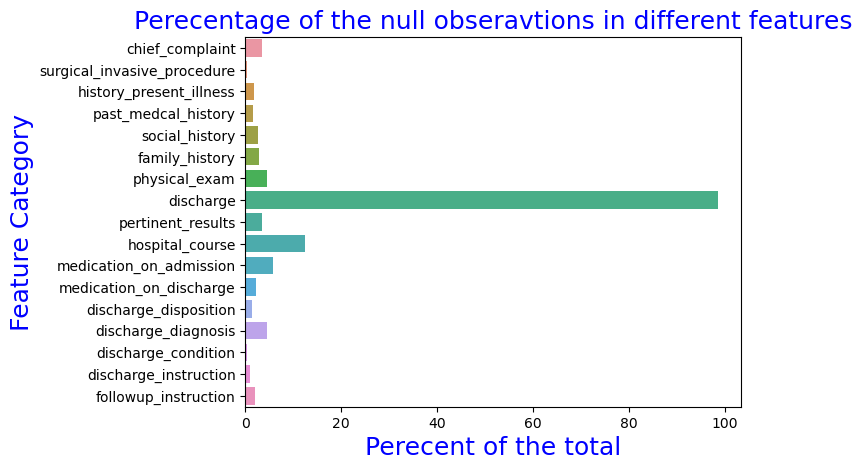

In [39]:
df=df_feastats
sns.barplot(data=df, x='percent_null_observation', y='feature_category')

plt.title('Perecentage of the null obseravtions in different features', fontsize=18,
         color='blue')
plt.ylabel('Feature Category', fontsize=18, color="blue")
plt.xlabel('Perecent of the total', fontsize=18, color="blue")

In [ ]:
#thoughts and flow
#identifing right variable for doing/predicating MULTILABEL CLASSIFICATION
#1. take one variable column to get tokens at a time and one icd
#2. take one variable column to get tokens at a time and all icd 
#3. take different variable columns and predict one icd
#4. take different variable columns and predict all icd
#5. concat all the column with the discharge label and usefor classification

#supervised classifiers and text representations


# categories = ['icd_E11', 'icd_E78','icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92','icd_Z85']
# variables = [ 'history_present_illness',
#        'past_medcal_history', 'social_history', 'family_history',
#        'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
#        'medication_on_admission', 'medication_on_discharge',
#        'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
#        'discharge_instruction', 'followup_instruction']
# x=df[variables]
# y=df[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [132]:
#dropping the discharge column as it is 98% null
df4model = df_text_ic.drop('discharge', axis=1).fillna('')

In [133]:
df4model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263941 entries, 0 to 263940
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   subject_id                   263941 non-null  int64 
 1   hadm_id                      263941 non-null  int64 
 2   icd                          263941 non-null  object
 3   long_title                   263941 non-null  object
 4   chief_complaint              263941 non-null  object
 5   surgical_invasive_procedure  263941 non-null  object
 6   history_present_illness      263941 non-null  object
 7   past_medcal_history          263941 non-null  object
 8   social_history               263941 non-null  object
 9   family_history               263941 non-null  object
 10  physical_exam                263941 non-null  object
 11  pertinent_results            263941 non-null  object
 12  hospital_course              263941 non-null  object
 13  medication_on_

In [219]:
categories = ['icd_E11', 'icd_E78','icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92','icd_Z85']

variables = [ 'history_present_illness', 'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction'] 

# df4model['dis_mer'] = df4model['discharge_disposition']+ df4model['discharge_diagnosis'] #these are object do we need to use astype(str)

train, test = train_test_split(df4model, random_state=42, test_size=0.33, shuffle=True)
X_train = train.discharge_instruction
X_test = test.discharge_instruction
y_train = train[categories]
y_test = test[categories]

print(X_train.shape)
print(X_test.shape)

(176840,)
(87101,)


In [ ]:

vector = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words

vector.fit(X_train)
X_train_vector = vector.transform(X_train)

X_test_vector = vector.transform(X_test)

NB = MultinomialNB().fit(X_train_vector, y_train)

y_pred = NB.predict(X_test_vector)

print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

In [220]:
# traing classifier

# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

var_pre = {}


for category in categories:
    print('... Processing {}'.format(category))
    
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    var_pre[category] = prediction
    
    
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

nb_pred = pd.DataFrame(var_pre)

print(nb_pred)

... Processing icd_E11
... Processing icd_E78
... Processing icd_E87
... Processing icd_F32
... Processing icd_I16
... Processing icd_I50
... Processing icd_N17
... Processing icd_Y92
... Processing icd_Z85
       icd_E11  icd_E78  icd_E87  icd_F32  icd_I16  icd_I50  icd_N17  icd_Y92  \
0            0        1        0        0        0        0        0        0   
1            0        0        0        0        1        0        0        0   
2            0        0        0        0        0        0        0        0   
3            0        0        0        0        0        0        1        0   
4            0        0        0        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
87096        0        0        1        0        0        0        0        0   
87097        0        0        0        0        0        0        0        0   
87098        0        0        1        0        0        0     

In [221]:
y_test.head(10)

,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
4039,0,1,0,0,1,1,0,0,0
196957,0,0,0,1,1,0,0,1,0
68719,1,1,0,0,1,0,0,0,0
18633,0,1,0,0,0,1,1,0,0
92713,1,0,0,0,0,0,0,0,0
223557,0,0,0,0,1,0,0,0,0
180840,0,0,1,0,0,0,1,1,0
191240,0,0,0,1,0,0,0,0,0
33080,1,1,0,1,1,1,0,0,0
29771,1,1,0,0,0,1,0,0,0


In [222]:
nb_pred.head()

,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0


In [208]:
y_test.reset_index().drop('index', axis=1)

type(y_test)

y_test.to_numpy().shape

(87101, 9)

In [209]:
nb_pred
type(nb_pred)
nb_pred.to_numpy().shape

(87101, 9)

In [210]:
abs(np.diff([y_test.to_numpy(), nb_pred.to_numpy()], axis=0))

(1, 87101, 9)

In [238]:
#percent of wrongly predicted ICD in the dataframe
print(y_test.columns, ((abs(np.diff([y_test.to_numpy(), nb_pred.to_numpy()], axis=0))).sum(axis=1)/len(y_test))*100)

# error = {}
# for i in y_test.columns:
#     keys = y_test.columns
#     values = ((abs(np.diff([y_test.to_numpy(), nb_pred.to_numpy()], axis=0))).sum(axis=1)/len(y_test))*100
#     error[keys] = values
# print(pd.DataFrame(error))

Index(['icd_E11', 'icd_E78', 'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50',
       'icd_N17', 'icd_Y92', 'icd_Z85'],
      dtype='object') [[29.44512692 38.93525907 20.76784423 20.3154958  30.30160389 15.68983135
  17.46018989 18.15937819 19.82870461]]


In [207]:
#row_wise addition
npx = abs(np.diff([y_test.to_numpy(), nb_pred.to_numpy()], axis=0))
npx.shape

npx.sum(axis=0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [223]:
y_true = y_test.to_numpy()
y_pred = nb_pred.to_numpy()

In [228]:
def Accuracy(y_true, y_pred):

    temp = 0
#     y_true = y_true.values
#     y_pred = y_pred.values
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]
    
#   Accuracy(y_true, y_pred)

In [229]:
Accuracy(y_true, y_pred)

0.1901903837963846

In [169]:
y_true

,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,0,1,0,0,1,1,0,0,0
1,0,0,0,1,1,0,0,1,0
2,1,1,0,0,1,0,0,0,0
3,0,1,0,0,0,1,1,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
87096,0,0,0,0,0,1,0,0,0
87097,0,0,0,1,0,0,0,0,0
87098,0,0,1,0,0,0,0,0,0
87099,1,1,0,0,0,0,1,0,1


In [239]:
#finding the accuracy score for the multilabel classification

# y_pred = nb_pred
# y_true = (y_test.reset_index().drop('index', axis=1))
Accuracy(y_true, y_pred)


#Exact Match Ratio
# np.all(nb_pred == (y_test.reset_index().drop('index', axis=1)), axis=1).mean()
np.any(y_true != y_pred, axis=1).mean()

0.9382670692644172

**Hamming_loss**
For the multilabel classification It reports how many times on average, the relevance of an example to a class label is incorrectly predicted. Therefore, hamming loss takes into account the prediction error (an incorrect label is predicted) and missing error (a relevant label not predicted), normalized over total number of classes and total number of examples.
    
where I is the indicator function. Ideally, we would expect the hamming loss to be 0, which would imply no error; practically the smaller the value of hamming loss, the better the performance of the learning algorithm.

In [242]:
def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])
    
# print('Hamming_loss with the discharge_instruction as variable is', Hamming_Loss(y_true, y_pred))

Hamming_loss with the discharge_instruction as variable is 0.23433714882722356


In [136]:
#MultiOutput Classifier

from sklearn.multioutput import MultiOutputClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', MultiOutputClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
            ])
# for category in categories:
# prit('... Processing {}'.format(category))
    
NB_pipeline.fit(X_train, train[categories])
    # compute the testing accuracy
prediction = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(test[categories], prediction)))

Test accuracy is 0.06173293073558283


In [ ]:
# traing classifier

# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [150]:
confusion_matrix(test[categories].values[:,8], prediction[:,8])

# test[categories].values[:,0]

array([[69563,   398],
       [16873,   267]], dtype=int64)

In [145]:
NB_pipeline.predict_proba(X_test)

[array([[0.67129963, 0.32870037],
        [0.91925506, 0.08074494],
        [0.67378768, 0.32621232],
        ...,
        [0.69917087, 0.30082913],
        [0.70876549, 0.29123451],
        [0.57777758, 0.42222242]]),
 array([[0.29406301, 0.70593699],
        [0.65383062, 0.34616938],
        [0.52985017, 0.47014983],
        ...,
        [0.67020318, 0.32979682],
        [0.62010217, 0.37989783],
        [0.43085946, 0.56914054]]),
 array([[0.96317245, 0.03682755],
        [0.99522349, 0.00477651],
        [0.85350075, 0.14649925],
        ...,
        [0.4559544 , 0.5440456 ],
        [0.42765355, 0.57234645],
        [0.78609214, 0.21390786]]),
 array([[0.94684227, 0.05315773],
        [0.98123706, 0.01876294],
        [0.88475992, 0.11524008],
        ...,
        [0.83197805, 0.16802195],
        [0.89397472, 0.10602528],
        [0.90149275, 0.09850725]]),
 array([[0.61980258, 0.38019742],
        [0.14460352, 0.85539648],
        [0.67973693, 0.32026307],
        ...,
        [

In [241]:
df4model

,subject_id,hadm_id,icd,long_title,chief_complaint,surgical_invasive_procedure,history_present_illness,past_medcal_history,social_history,family_history,...,followup_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,10000980,29654838,I50,"Congestive heart failure, unspecified",Shortness of breath\n,None\n,"___ yo woman with h/o hypertension, hyperlipid...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",___,Denies cardiac family history. Family hx of DM...,...,___\n,1,1,0,0,0,1,0,0,0
1,10000980,26913865,I50,Acute on chronic systolic heart failure,dyspnea\n,Cardiac catheterization ___\n\n,"This is a ___ M with history of diabetes, dias...",- hypertension\n- diabetes\n- hx CVA (cerebell...,___,"Niece had some sort of cancer. Otherwise, no f...",...,___\n,1,0,0,0,0,1,0,0,0
2,10000980,24947999,I50,Acute on chronic systolic heart failure,Dyspnea and chest tightness\n,___ Pharmacologic nuclear stress test\n,"___ year old female with history of HTN, HLD, ...",- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,1,0,0,0,1,0,0,0
3,10000980,25242409,I50,"Congestive heart failure, unspecified",DVT\n,EGD\n\n,This is a ___ y/o female with PMHx significant...,- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,1,0,0,0,1,1,1,0
4,10000980,25911675,I50,Acute on chronic systolic (congestive) heart f...,"fatigue, anemia\n",None\n\n,Ms. ___ is a ___ year old woman with a past me...,- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263936,19995832,23014132,Z85,Personal history of malignant neoplasm of bladder,sustained VT \n,cardiac cath: ___\n- No angiographically appar...,"___ y/o M with history of bladder cancer, lymp...","- ""Blood cancer"" s/p chemotherapy, none for pa...",___,- Father died of old age (no cardiac history)\...,...,___\n,0,0,0,0,0,0,0,0,1
263937,19997367,23127303,Z85,Personal history of malignant neoplasm of breast,hypotension\n,none \n\n,___ yo F h/o AML s/p allogenic BMT referred fr...,- Severe mitral stenosis (area < 1.0cm2) s/p M...,___,Breast cancer in mother and sister \n\n,...,___\n,0,0,0,0,0,0,0,0,1
263938,19997367,27185507,Z85,Personal history of malignant neoplasm of breast,Hemoptysis and melanotic stools\n,EGD with MAC Anesthesia\n\n,Ms. ___ is a ___ with a PMHx of AML (sp T-cell...,- Severe mitral stenosis (area < 1.0cm2) s/p M...,___,Breast cancer in mother and sister.\n\n,...,___\n,0,0,0,0,0,0,0,0,1
263939,19997576,25548363,Z85,Personal history of other malignant neoplasm o...,,None\nattach\n,,,,,...,___\n,0,0,0,0,0,0,0,0,1


In [293]:
# 3Scanning for model
df4model['hospital_course'].iloc[0]
# df4model['social_history'].isna().sum()

" woman with h/o hypertension, hypelipidemia, diabetes mellitus on insulin, cerebellarmedullary stroke in , stage  CKD followed by   presenting with fatigue and DOE for a few weeks, markedly worse the morning of admission. The patient has known diastolic dysfunction. Of note, she has been noncompliant with her medications at home. On arrival to the floor, she required hydralazine 20 mg to bring down her BP. She has likely had elevated BPs at home for a while, which is contributing to her SOB, CHF exacerbation, and secondary demand myonecrosis (hypertensive urgency) with mildly elevated troponin.# CAD: Although she did not have a classic anginal presentation, patient has several risk factors for acute coronary syndrome. Her only symptom was SOB in the setting of elevated BPs attributed to medication noncompliance at home. Her troponin fell from 0.05 at admission to 0.01 at discharge in the setting of renal dysfunction, but there was not a clear rise and fall to suggest an acute infarcti

In [253]:
#checking how the text looks like in the variable column 
df4model['history_present_illness'].iloc[0]
# df4model['social_history'].isna().sum()

df4model.columns

Index(['subject_id', 'hadm_id', 'icd', 'long_title', 'chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction', 'icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85'],
      dtype='object')

In [288]:
#one by one cleaning all the columns and assinging back
df4model[
#     'chief_complaint'
#     'surgical_invasive_procedure'
#     'history_present_illness'
#     'past_medcal_history' 
#     'social_history' 
#     'family_history'
#     'physical_exam' 
#     'pertinent_results'
#     'hospital_course'
#     'medication_on_admission' 
#     'medication_on_discharge'
#     'discharge_disposition' 
#     'discharge_diagnosis'
#     'discharge_condition'
#     'discharge_instruction' 
#     'followup_instruction'
] = (df4model[
#     'chief_complaint'
#     'surgical_invasive_procedure'
#     'history_present_illness'
#     'past_medcal_history' 
#     'social_history' 
#     'family_history'
#     'physical_exam' 
#     'pertinent_results'
#     'hospital_course'
#     'medication_on_admission' 
#     'medication_on_discharge'
#     'discharge_disposition' 
#     'discharge_diagnosis'
#     'discharge_condition'
#     'discharge_instruction' 
#     'followup_instruction'
].str.replace('\n', '')
    .str.replace('=', '')
    .str.replace('-', '')
    .str.replace('_', '')
     .str.replace('Mr.', '')
     .str.replace('Ms.', '')
     .str.replace('Mrs.', '')
     .str.replace('Mrs', '')
     .str.replace('Mr', '')
     .str.replace('Ms', '')
     .str.replace('Dr', '')
     .str.replace('Dr.', ''))


C:\Users\upadh\AppData\Local\Temp\ipykernel_15820\73776553.py:19: FutureWarning:

The default value of regex will change from True to False in a future version.



In [290]:
df4model.to_csv('../data/df4model.csv', index=False)

In [292]:
df4model = pd.read_csv('../data/df4model.csv')